# mlbotの初心者向けチュートリアル(FTX版)

richmanbtcさんのmlbotの初心者向けチュートリアルをFTX向けに記載したものです。


In [1]:
import math
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import numba


期間指定

In [2]:
df = pd.read_pickle('./model_make/df_ohlcv_bybit_with_fee060.pkl')
df['fee']  = 0.0004

display(df)


,op,hi,lo,cl,volume,turnover,fee
timestamp,,,,,,,
2020-03-25 09:00:00+00:00,6500.0,6628.5,6457.5,6511.5,438.877,2.857748e+06,0.0004
2020-03-25 21:00:00+00:00,6511.5,6745.5,6502.0,6698.5,1370.643,9.181252e+06,0.0004
2020-03-26 09:00:00+00:00,6698.5,6767.0,6555.0,6598.5,1754.275,1.157558e+07,0.0004
2020-03-26 21:00:00+00:00,6598.5,6760.0,6512.0,6733.5,2150.689,1.448166e+07,0.0004
2020-03-27 09:00:00+00:00,6733.5,6838.0,6595.0,6617.5,2366.066,1.565744e+07,0.0004
...,...,...,...,...,...,...,...
2024-11-01 21:00:00+00:00,70034.6,71650.0,68800.0,69495.5,119552.020,8.376895e+09,0.0004
2024-11-02 09:00:00+00:00,69495.5,69919.0,69387.5,69597.5,16904.115,1.177049e+09,0.0004
2024-11-02 21:00:00+00:00,69597.5,69687.0,68981.6,69363.6,26643.592,1.847748e+09,0.0004


In [3]:
features = sorted([
    'ATR_shift',
])


In [4]:
import datetime

def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    orig_columns = df.columns
    hilo = (df['hi'] + df['lo']) / 2
    # ATRを計算する関数
    def calculate_atr(high, low, close, timeperiod):
        tr = np.maximum(high - low, np.abs(high - close.shift(1)), np.abs(low - close.shift(1)))
        atr = tr.rolling(window=timeperiod).mean()
        return atr

    # ATRを計算する12.8.6
    timeperiod = 6
    df['ATR_2'] = calculate_atr(df['hi'], df['lo'], df['cl'], timeperiod)
    df['ATR_shift'] = df['ATR_2'].shift(1)
    df['ATR_shift'] = np.floor(df['ATR_shift'] * 10) / 10
    return df


In [5]:
df = calc_features(df)
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time
display(df)

,op,hi,lo,cl,volume,turnover,fee,ATR_2,ATR_shift
timestamp,,,,,,,,,
2020-03-25 09:00:00+00:00,6500.0,6628.5,6457.5,6511.5,438.877,2.857748e+06,0.0004,NaN,NaN
2020-03-25 21:00:00+00:00,6511.5,6745.5,6502.0,6698.5,1370.643,9.181252e+06,0.0004,NaN,NaN
2020-03-26 09:00:00+00:00,6698.5,6767.0,6555.0,6598.5,1754.275,1.157558e+07,0.0004,NaN,NaN
2020-03-26 21:00:00+00:00,6598.5,6760.0,6512.0,6733.5,2150.689,1.448166e+07,0.0004,NaN,NaN
2020-03-27 09:00:00+00:00,6733.5,6838.0,6595.0,6617.5,2366.066,1.565744e+07,0.0004,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2024-11-01 21:00:00+00:00,70034.6,71650.0,68800.0,69495.5,119552.020,8.376895e+09,0.0004,1702.616667,1687.3
2024-11-02 09:00:00+00:00,69495.5,69919.0,69387.5,69597.5,16904.115,1.177049e+09,0.0004,1643.933333,1702.6
2024-11-02 21:00:00+00:00,69597.5,69687.0,68981.6,69363.6,26643.592,1.847748e+09,0.0004,1496.650000,1643.9


In [6]:


# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.1

limit_price_dist_2 = df['ATR_shift'] * 0.25
limit_price_dist_2 = np.maximum(1, (limit_price_dist_2 / pips).round().fillna(1)) * pips

limit_price_dist = df['ATR_shift'] * 0.21
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist_2
df['sell_price'] = df['cl'] + limit_price_dist


# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values,  # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1  # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee']  # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_e'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_e'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_e'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_e'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_e'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_e'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)


In [7]:
df['y_pred_buy'] = 1
df['y_pred_sell'] = 1

累積

In [8]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol

        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss


グラフ

In [9]:

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)
display(df)


,op,hi,lo,cl,volume,turnover,fee,ATR_2,ATR_shift,buy_price,...,buy_e,sell_e,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell,cum_ret,poss
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-03-25 09:00:00+00:00,6500.0,6628.5,6457.5,6511.5,438.877,2.857748e+06,0.0004,NaN,NaN,6511.4,...,1.0,1.0,0.027950,-0.029487,0.000385,0.000385,1,1,-0.000769,0.0
2020-03-25 21:00:00+00:00,6511.5,6745.5,6502.0,6698.5,1370.643,9.181252e+06,0.0004,NaN,NaN,6698.4,...,1.0,1.0,-0.015699,0.014158,0.000385,0.000385,1,1,-0.001539,0.0
2020-03-26 09:00:00+00:00,6698.5,6767.0,6555.0,6598.5,1754.275,1.157558e+07,0.0004,NaN,NaN,6598.4,...,1.0,1.0,0.019690,-0.021229,0.000385,0.000385,1,1,-0.002309,0.0
2020-03-26 21:00:00+00:00,6598.5,6760.0,6512.0,6733.5,2150.689,1.448166e+07,0.0004,NaN,NaN,6733.4,...,1.0,1.0,-0.017998,0.016457,0.000385,0.000385,1,1,-0.003079,0.0
2020-03-27 09:00:00+00:00,6733.5,6838.0,6595.0,6617.5,2366.066,1.565744e+07,0.0004,NaN,NaN,6617.4,...,1.0,1.0,-0.059176,0.039048,0.000385,0.000385,1,1,-0.003849,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01 21:00:00+00:00,70034.6,71650.0,68800.0,69495.5,119552.020,8.376895e+09,0.0004,1702.616667,1687.3,69073.7,...,0.0,1.0,0.000000,0.008905,0.000000,-0.004698,1,1,0.824246,-1.0
2024-11-02 09:00:00+00:00,69495.5,69919.0,69387.5,69597.5,16904.115,1.177049e+09,0.0004,1643.933333,1702.6,69171.9,...,1.0,0.0,NaN,0.000000,-0.005715,0.000000,1,1,0.832316,1.0
2024-11-02 21:00:00+00:00,69597.5,69687.0,68981.6,69363.6,26643.592,1.847748e+09,0.0004,1496.650000,1643.9,68952.6,...,1.0,0.0,NaN,0.000000,-0.005525,0.000000,1,1,0.817628,1.0


,op,hi,lo,cl,volume,turnover,fee,ATR_2,ATR_shift,buy_price,...,buy_e,sell_e,y_buy,y_sell,buy_cost,sell_cost,y_pred_buy,y_pred_sell,cum_ret,poss
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-30 09:00:00+00:00,72757.5,72813.6,71930.0,72000.0,35768.317,2.588439e+09,0.0004,1683.933333,1603.6,71599.1,...,1.0,1.0,-0.017575,0.006807,-0.005168,-0.004278,1,1,0.825307,-1.0
2024-10-30 21:00:00+00:00,72000.0,73044.2,71455.1,72386.3,77055.616,5.559362e+09,0.0004,1746.683333,1683.9,71965.3,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1,1,0.827561,-1.0
2024-10-31 09:00:00+00:00,72386.3,72736.4,72056.5,72223.1,30554.234,2.211155e+09,0.0004,1650.883333,1746.6,71786.5,...,1.0,0.0,-0.020142,0.000000,-0.005645,0.000000,1,1,0.812672,1.0
2024-10-31 21:00:00+00:00,72223.1,72280.6,69719.3,70332.3,107172.632,7.592100e+09,0.0004,1730.316667,1650.8,69919.6,...,1.0,0.0,0.006042,0.000000,-0.005468,0.000000,1,1,0.808439,1.0
2024-11-01 09:00:00+00:00,70332.3,70506.8,68855.0,70034.6,57179.907,3.980374e+09,0.0004,1687.350000,1730.3,69602.0,...,1.0,1.0,0.002760,0.016617,-0.005777,-0.004789,1,1,0.825714,-1.0
2024-11-01 21:00:00+00:00,70034.6,71650.0,68800.0,69495.5,119552.020,8.376895e+09,0.0004,1702.616667,1687.3,69073.7,...,0.0,1.0,0.000000,0.008905,0.000000,-0.004698,1,1,0.824246,-1.0
2024-11-02 09:00:00+00:00,69495.5,69919.0,69387.5,69597.5,16904.115,1.177049e+09,0.0004,1643.933333,1702.6,69171.9,...,1.0,0.0,NaN,0.000000,-0.005715,0.000000,1,1,0.832316,1.0
2024-11-02 21:00:00+00:00,69597.5,69687.0,68981.6,69363.6,26643.592,1.847748e+09,0.0004,1496.650000,1643.9,68952.6,...,1.0,0.0,NaN,0.000000,-0.005525,0.000000,1,1,0.817628,1.0
2024-11-03 09:00:00+00:00,69363.6,69382.9,67820.0,68344.8,48184.144,3.298248e+09,0.0004,1643.816667,1496.6,67970.7,...,1.0,0.0,NaN,0.000000,-0.005074,0.000000,1,1,0.815044,1.0


C:\Users\管理\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\管理\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\管理\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\管理\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\管理\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED S

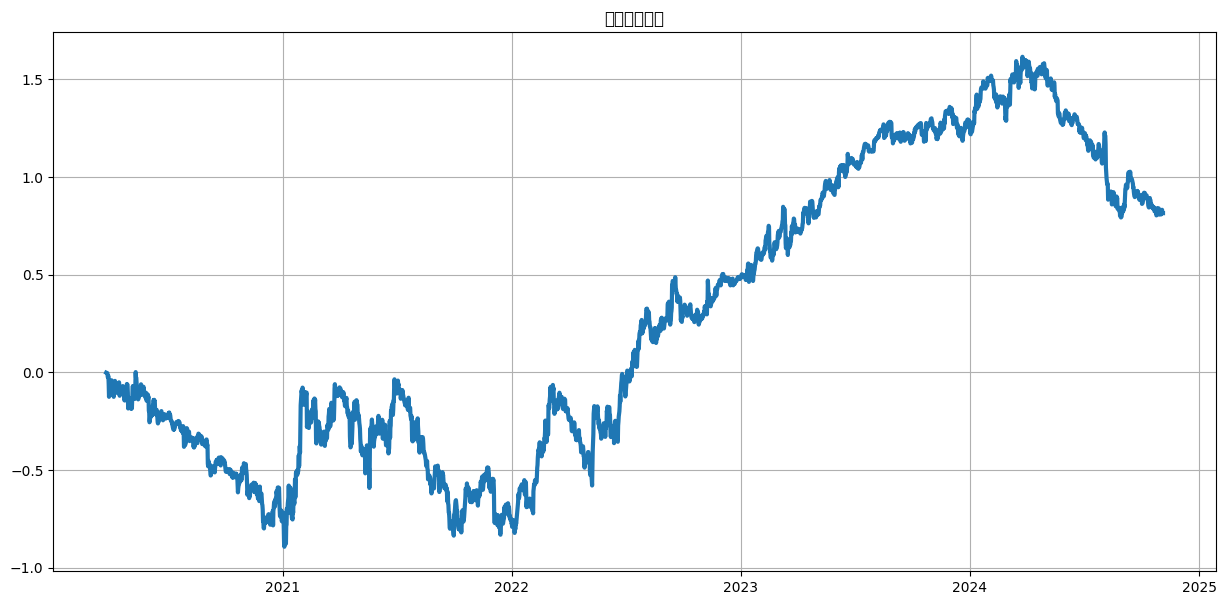

In [10]:

display(df.tail(10))  # 最後の30行を表示
plt.figure(figsize=(15, 7))
plt.plot(df['cum_ret'], label='cum_ret', linewidth=3)
plt.title('累積リターン')
plt.grid()
plt.show()